# Structural Connectivity Matrices

This tutorial will give an introduction to the dipy tools which can be used to generate connectivity matrices for structural connectivity analyses. For more options please check the dipy tutorials online https://workshop.dipy.org/documentation/0.16.0./examples_built/streamline_tools/.

The first step is to generate a set of streamlines. We will follow the same steps covered in the HARDI tractography tutorial to generate a whole brain tractogram using probabilistic CSD tractography. For this example we will use a sample dataset provided with dipy, the Stanford HARDI dataset which consists of a single subject’s diffusion, b-values and b-vectors, and some labels defined after freesurfer segmentation.


In [1]:
#load genral modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

#load the relevant dipy modules
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines
from dipy.direction import ProbabilisticDirectionGetter
from dipy.data import get_sphere
from dipy.viz import has_fury, window, actor, colormap as cmap

In [2]:
#load the Stanford HARDI dataset

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')
t1_fname = get_fnames('stanford_t1')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
t1_data = load_nifti_data(t1_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

In [3]:
#This step will take several minutes to run 

#define a white matter mask using labels 1 and 2
white_matter = binary_dilation((labels == 1) | (labels == 2))

#estimate response function
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

#define and fit the CSD model to the data
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order_max=6)
csd_fit = csd_model.fit(data, mask=white_matter)

# define the seeds and stopping criterion
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

#load the directions evenly distributed on a sphere
sphere = get_sphere('symmetric724')

# define the PMF from the ODF
fod = csd_fit.odf(sphere)
pmf = fod.clip(min=0)

# instanciate the probabilistic direction getter
prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30.,
                                                sphere=sphere)

# initialise the streamlines generator
streamline_generator_prob = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=0.5)


# generate the streamlines
streamlines = Streamlines(streamline_generator_prob)

100%|███████████████████████████████████| 96983/96983 [00:17<00:00, 5517.63it/s]


## Using a target ROI (Region of Interest)

The first of the tracking utilities we will cover in this tutorial is "target". This function takes a set of streamlines and a region of interest (ROI) and returns only those streamlines that pass though the ROI. The ROI should be an array such that the voxels that belong to the ROI are True and all other voxels are False (binary mask). 

This function can also exclude all the streamlines that pass though an ROI by setting the "include" flag to False. In this example we will target the streamlines of the corpus callosum. We will use a previously defined mask (a sagittal slice over the corpus callosum) and create two sets of streamlines, those that intersect with the ROI and those that don’t.

In [4]:
#select a sagittal slice of the corpus callosum (label = 2)
cc_slice = labels == 2

#use the utils.target function to select the streamlines that pass through the CC slice
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

#select the streamlines that do not pass through the CC slice
other_streamlines = utils.target(streamlines, affine, cc_slice,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)

#check that the number of streamlines is the same
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

We can use dipy tools to visualise the two sets of tracts:

In [5]:
from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(cc_streamlines)

    streamlines_actor = actor.line(cc_streamlines,
                                   colormap.line_colors(cc_streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='csd_tractogram_cc_target.png', size=(800, 800))
    window.show(scene)

/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the line function in future versions of FURY.

Here's how to call the Function line: line(lines_value, colors='value', opacity='value', linewidth='value', spline_subdiv='value', lod='value', lod_points='value', lod_points_size='value', lookup_colormap='value', depth_cue='value', fake_tube='value')

  exec(code_obj, self.user_global_ns, self.user_ns)
/cognestic/miniconda3/envs/mri/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: We'll no longer accept the way you call the record function in future versions of FURY.

Here's how to call the Function record: record(scene='value', cam_pos='value', cam_focal='value', cam_view='value', out_path='value', path_numbering='value', n_frames='value', az_ang='value', magnification='value', size='value', reset_camera='value', screen_clip='value', stereo='value', verbose

Next, we might want to find out which regions of the brain are connected by these streamlines. To do this we can use the "connectivity_matrix" function. This function takes a set of streamlines and an array of labels as arguments. It returns the number of streamlines that start and end at each pair of labels and it can return the streamlines grouped by their endpoints. Notice that this function only considers the endpoints of each streamline.

The set of labels can be defined in many ways, but one typical approach is to use the cortical parcellation from FreeSurfer. Because "recon-all" takes several hours, this step has already been performed for the Stanford HARDI dataset. 

The image aparc-reduced.nii.gz, which we load as labels_img, is a modified version of the label map aparc+aseg.mgz created by FreeSurfer. The corpus callosum region is a combination of the FreeSurfer labels 251-255. The remaining FreeSurfer labels were re-mapped and reduced so that they lie between 0 and 88. To see the FreeSurfer region, label and name, represented by each value, see label_info.txt in ~/.dipy/stanford_hardi.



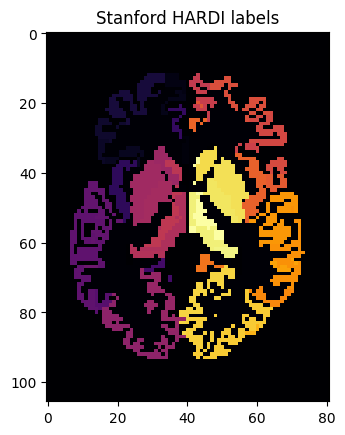

In [6]:
#select a slice to plot
slice_z = labels[:, :, 30]

# Plot the slice showing the labels
plt.imshow(np.rot90(slice_z), cmap='inferno')
plt.title('Stanford HARDI labels')
plt.show()

We are now ready to create the connectivity matrix for the corpus callosum:

In [11]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True,
                                        symmetric=True)
M[:3, :] = 0
M[:, :3] = 0

And finally, we can display the connectivity matrix:

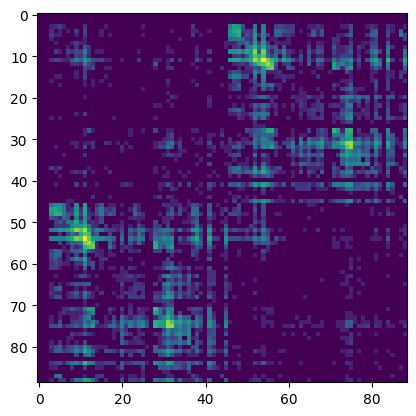

In [12]:
plt.imshow(np.log1p(M), interpolation='nearest')
#plt.savefig("connectivity.png")